In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pprint
import math

In [31]:
data = {}
with open("results.csv", "r") as f:
    lines = [line.rstrip() for line in f]
    headers = lines[0].split(",")
    
    duration = int(lines[5].split(",")[1]) / 1000  # duration in seconds
    n_list = [int(x) for x in lines[6].split(",")[1][:-1].split(":")]
    
    for line in lines[1:4]:
        parts = line.split(",")
        data[parts[0]] = {
            headers[1]: int(parts[1]),
            headers[2]: int(parts[2]),
            headers[3]: int(parts[3]),
            headers[4]: int(parts[4]),
        }


print(duration)
print(data)

metrics = {name: {} for name in data.keys()}

for key in metrics.keys():
    metrics[key]["Throughput"] = data[key]["frameDisplayed"] / duration
    metrics[key]["Percent of Errors Corrected"] = 1 - (data[key]["errorCountAC"] / data[key]["errorCountBC"])
    
    baseline_receiver = 0.01
    baseline_sender = 0.01
    p_cycle_node = 0.0000082  # J
    p_cycle_sat = 0.0000082  # J

    if key == "Standard":
        ec = (baseline_sender * data[key]["frameCount"]) + (baseline_receiver * data[key]["frameCount"])
    elif key == "Corrected":
        n = 22
        k = 18
        M = math.ceil(18 / k)

        # These are the iterations
        iter_encoding = M * k * (n - k)
        iter_decoding = M * n * (n - k)

        e_encoding = iter_encoding * p_cycle_node
        e_decoding = iter_decoding * p_cycle_sat
        ec = (baseline_sender * data[key]["frameCount"]) + (baseline_receiver * data[key]["frameCount"]) + (e_encoding * data[key]["frameCount"]) + (e_decoding * data[key]["frameCount"])
    elif key == "CorrectedML":
        ec = 0
        for n in n_list:
            k = 18
            M = math.ceil(18 / k)

            # These are the iterations
            iter_encoding = M * k * (n - k)
            iter_decoding = M * n * (n - k)

            e_encoding = iter_encoding * p_cycle_node
            e_decoding = iter_decoding * p_cycle_sat
            ec += baseline_sender + baseline_receiver + e_encoding + e_decoding
            
    metrics[key]["Energy Consumption"] = ec
    metrics[key]["Energy Efficiency"] = data[key]["frameDisplayed"] / ec


pprint.pprint(metrics)

22.47
{'Standard': {'frameCount': 656, 'frameDisplayed': 171, 'errorCountBC': 485, 'errorCountAC': 485}, 'Corrected': {'frameCount': 667, 'frameDisplayed': 338, 'errorCountBC': 488, 'errorCountAC': 329}, 'CorrectedML': {'frameCount': 654, 'frameDisplayed': 448, 'errorCountBC': 501, 'errorCountAC': 206}}
{'Corrected': {'Energy Consumption': 14.215104,
               'Energy Efficiency': 23.77752565158862,
               'Percent of Errors Corrected': 0.3258196721311475,
               'Throughput': 15.042278593680464},
 'CorrectedML': {'Energy Consumption': 14.905877599999974,
                 'Energy Efficiency': 30.055258202308114,
                 'Percent of Errors Corrected': 0.5888223552894212,
                 'Throughput': 19.937694704049846},
 'Standard': {'Energy Consumption': 13.120000000000001,
              'Energy Efficiency': 13.033536585365853,
              'Percent of Errors Corrected': 0.0,
              'Throughput': 7.610146862483312}}


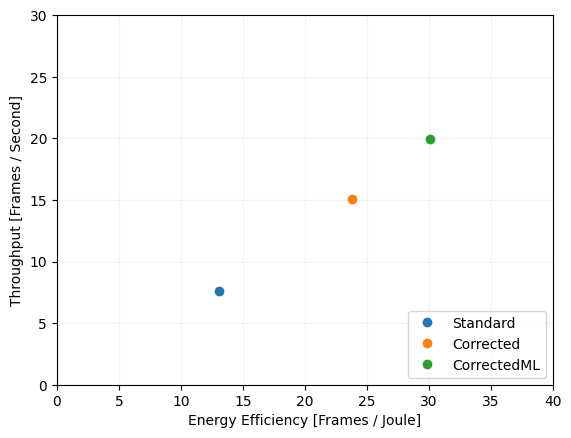

In [33]:
output_dir = "output_graphs"

fig = plt.figure()
ax = fig.add_subplot(111)

for name in metrics.keys():
    x = metrics[name]["Energy Efficiency"]
    y = metrics[name]["Throughput"]
    plt.plot([x], [y], 'o', label=name)

y_label = "Throughput [Frames / Second]"
x_label = "Energy Efficiency [Frames / Joule]"
plt.ylabel(y_label)
plt.xlabel(x_label)
plt.legend(loc="lower right", numpoints=1)
plt.grid(linestyle='-', color='0.95')

plt.ylim(0, 30)
plt.xlim(0, 40)

plt.savefig(os.path.join(output_dir, f"{(x_label + y_label).replace(' ', '_').replace('/', '_')}.png"))
plt.show()

# def plot_runs(metric_names, label, ylims, is_log=False, show_metric_name=False):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
# 
#     for metric in metric_names:
#         for channel_code in results:
#             x = list(results[channel_code][metric].keys())[1:]
#             ys = [results[channel_code][metric][BER] for BER in x]
#             y = [np.average(y) for y in ys]
#             yerr = [np.std(y) for y in ys]
# 
#             key_label = channel_code if not show_metric_name else f"{metric} - {channel_code}"
#             plt.errorbar(x, y, yerr=yerr, label=key_label, capsize=4, clip_on=False)
# 
#     plt.ylabel(label)
#     plt.xlabel("BER")
#     plt.legend(loc="lower left")
#     plt.grid(linestyle='-', color='0.95')
# 
#     if is_log:
#         plt.yscale("log")
#     plt.xscale("log")
#     
#     plt.ylim(ylims[0], ylims[1])
#     plt.xlim(min(x), max(x))
# 
#     plt.savefig(os.path.join(output_dir, f"{label.replace(' ', '_').replace('/', '_')}.png"))
#     plt.show()
# 
# 
# metric = "Energy Efficiency Node"
# plot_runs([metric], "Energy Efficiency Node [bytes / joule]", [0, 250])
# 
# metric = "Energy Consumption Node"
# plot_runs([metric], "Energy Consumption Node [joule]", [0, 400])
# 
# metric = "Energy Efficiency Satellite"
# plot_runs([metric], "Energy Efficiency Satellite [bytes / joule]", [0, 3500])
# 
# metric = "Energy Consumption Satellite"
# plot_runs([metric], "Energy Consumption Satellite [joule]", [0, 400])
# 
# metric = "Throughput"
# plot_runs([metric], "Throughput kilobytes / hour", [0, 350])
# 
# plot_runs(["Overhead", "Data"], "Overhead and data [bytes]", [0, 70000], show_metric_name=True)